# Sidekick - Project-Based Predictions
Scratch work for Sidekick to perform predictions on single projects.

## Import
Import and general settings. Should be run every time at first.

In [205]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import cPickle as cp
import matplotlib.pyplot as plt
from math import floor
import sys
sys.stdout.flush() # Print output on the fly in Notebook

DATA_DIR = "../data/kickstarter-etter-cosn2013"

## Load data
This operation takes a lot of time, should be done only once.

In [10]:
def load_binary(file_name):
    with open(file_name, 'rb') as f:
        return cp.load(f)


def load_data():
    print 'Loading projects...'
    projects = np.load('%s/projects.npy' % (DATA_DIR, ))
    print 'Loading statuses...'
    statuses = load_binary('%s/statuses.pkl' % (DATA_DIR, ))
    print 'Loading tweets...'
    tweets = np.load('%s/tweets.npy' % (DATA_DIR, ))
    print 'Loading graph...'
    graph = np.load('%s/graph.pkl' % (DATA_DIR, ))

    # conver to numpy arrays if needed
    statuses = np.array(statuses)

    return projects, statuses, tweets, graph


def load_project(project_id):
    data = load_binary("%s/project_%s.pkl" % (DATA_DIR, project_id))
    project = data["project"]
    status = data["status"]
    tweet = data["tweet"]
    return project, status, tweet

#projects, statuses, tweets, graph = load_data()

## Extract one project
**Optional:** Save the project in the data directory

In [420]:
index = 0
#project_id = "52687"

def extract_project(index, projects, statuses, tweets, save=False):
    project = projects[index]
    status = statuses[index]
    tweet = tweets[index]
    if save:
        project_id = str(project[0])
        print "Project %s" % project_id
        data = {"project": project,
                "status": status,
                "tweet": tweet}
        with open("%s/project_%s.pkl" % (DATA_DIR, project_id), "wb") as f:
            cp.dump(data, f)
    return project, status, tweet

project, status, tweet = extract_project(index, projects, statuses, tweets, save=True)
#project, status, tweet = load_project(project_id)

Project 52687


## Plot status
Plot the pledged money and number of backers of the same figure.

Goal: $1200
Pledged: $1201


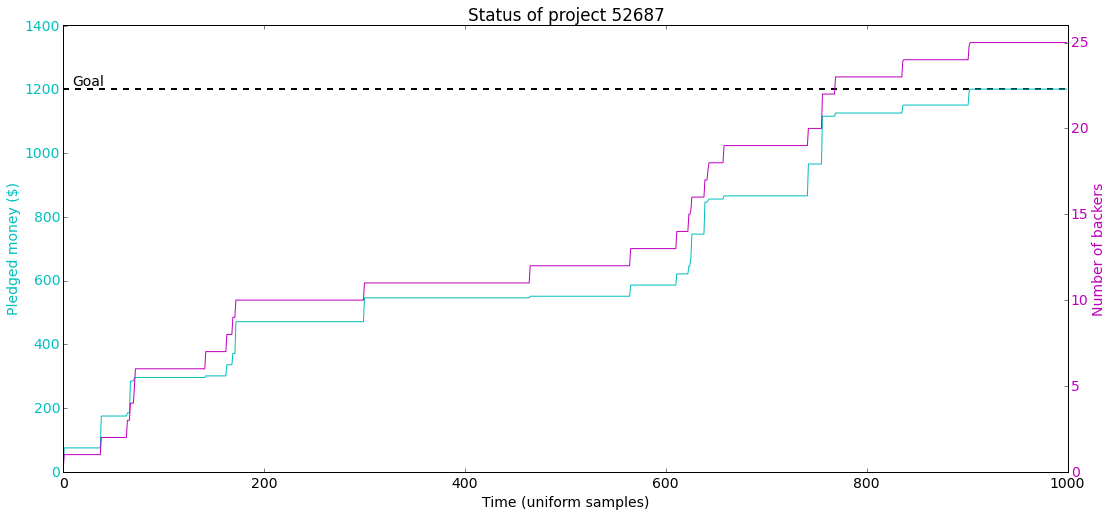

In [436]:
def plot_status(project, status):
    x = np.arange(len(status))
    goal = project[1]
    money = status[:, 1]
    backers = status[:, 2]
    project_id = project[0]
    print "Goal: $%s" % goal
    print "Pledged: $%s" % int(money[-1] * goal)
    
    # Pledged money
    fig, ax1 = plt.subplots()
    ax1.plot(x, money * goal, 'c-')
    ax1.set_xlabel('Time (uniform samples)')
    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel('Pledged money ($)', color='c')
    ax1.set_ylim([0, max(ax1.get_ylim()[1] + 1, goal + goal*0.05)])
    for tl in ax1.get_yticklabels():
        tl.set_color('c')
        
    # Number of backers
    ax2 = ax1.twinx()
    ax2.plot(x, backers, 'm-')
    ax2.set_ylabel('Number of backers', color='m')
    ax2.set_ylim([0, ax2.get_ylim()[1] + 1])
    for tl in ax2.get_yticklabels():
        tl.set_color('m')
        
    # Goal
    line = ax1.axhline(y=goal, color="k", linestyle="--", linewidth=2, zorder=0)
    ax1.text(10, goal + goal*0.01, "Goal")
    
    plt.title("Status of project %s" % project_id)
    plt.show()
    
plot_status(project, status)

## Processing
We keep only the observations where there is a change from the previous one in order to reduce the quantity of data. The training and testing sets are also extracted. 

**Default size**: 80% for trainig, 20% for testing

In [464]:
def split(X, Y, threshold=0.8):
    assert len(X) == len(Y)
    size = len(X)
    train_size = int(floor(size * threshold))
    Xtrain = np.array(X[:train_size])
    Ytrain = np.array(Y[:train_size])
    Xtest = np.array(X[train_size:])
    Ytest = np.array(Y[train_size:])
    return Xtrain, Ytrain, Xtest, Ytest


def subsample(Y):
    clean = [(0, 0)]
    seen = [0]
    for i in xrange(1, len(Y)):
        if Y[i] != Y[i-1]:
            if i-1 not in seen:
                clean.append((i-1, Y[i-1]))
            clean.append((i, Y[i]))
    if i not in seen:
        clean.append((i, Y[i-1]))
    l = zip(*clean)
    X = l[0]
    Y = l[1]
    return X, Y


def difference_series(Y):
    diff = [(0, 0)]
    seen = [0]
    for i in xrange(1, len(Y)):
        if Y[i] != Y[i-1]:
            diff.append((i, Y[i] - Y[i-1]))
    l = zip(*diff)
    X = l[0]
    Y = l[1]
    return X, Y

observations = status[:, 1]
X, Y = subsample(observations)
Xtrain, Ytrain, Xtest, Ytest = split(X, Y)

## Training
Perform the regression on the training set.

### Kernels
We define some kernels to be tried.

In [469]:
# Primitives
LIN = GPy.kern.Linear(input_dim=1)
SE = GPy.kern.RBF(input_dim=1)
BR = GPy.kern.Brownian(input_dim=1) # √
POLY = GPy.kern.Poly(input_dim=1, order=3) # x
RQ = GPy.kern.RatQuad(input_dim=1)
WN = GPy.kern.White(input_dim=1)
MAT = GPy.kern.Matern32

# Combined
LIN_LINxSE = LIN.copy() + LIN.copy() * SE.copy() # √
SE_LINxSE = SE.copy() + LIN.copy() * SE.copy()
SE_SExSE = SE.copy() + SE.copy() * SE.copy()
LINxSE = LIN.copy() + SE.copy()
LINxLIN = LIN.copy() + LIN.copy()
BRxSE = BR.copy() * SE.copy()
BR_SE = BR.copy() + SE.copy()
BR_SExLIN = BR.copy() + SE.copy() * LIN.copy()
BRxBR = BR.copy() * BR.copy()
BR_BR = BR.copy() + BR.copy()
SE_POLY = SE.copy() * POLY.copy() # x
RQxSE = RQ.copy() + SE.copy() # √
LINxSE_RQxSE = RQxSE.copy() + LINxSE.copy()
LINxSE_SE = RQxSE.copy() + SE.copy()
LINxRQ = LIN.copy() * RQ.copy() # √
LINxRQxBR = LINxRQ.copy() * BR.copy() # √
LINxRQ_BR = LINxRQ.copy() + BR.copy()
LINxRQxBR_SE = LINxRQxBR.copy() + SE.copy()
RQxSE_WN = RQxSE.copy() + WN.copy()

### Regression

In [476]:
kernel = SE
X = np.ndarray(shape=(len(Xtrain), 1), buffer=Xtrain, dtype=int)
Y = np.ndarray(shape=(len(Ytrain), 1), buffer=Ytrain, dtype=float)
m = GPy.models.GPRegression(X, Y, kernel)
m.optimize_restarts(num_restarts=10)
display(m)

Optimization restart 1/10, f = -56.042226865
Optimization restart 2/10, f = -56.0422268651
Optimization restart 3/10, f = 4.64107883231
Optimization restart 4/10, f = -56.0422268652
Optimization restart 5/10, f = -56.0422268651
Optimization restart 6/10, f = -56.0422268651
Optimization restart 7/10, f = -56.0422268652
Optimization restart 8/10, f = -56.0422268651
Optimization restart 9/10, f = -56.0422268651
Optimization restart 10/10, f = -56.0422268648


GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.185412364787,+ve,,
rbf.lengthscale,38.3778951752,+ve,,
Gaussian_noise.variance,0.000882318191514,+ve,,


## Evaluation
Predict the last 20% (test sets) and displays the Root Mean Squared Error and plots the model. In red, the predictions, in blue the actual values.

RMSE on test set: 0.814659660827


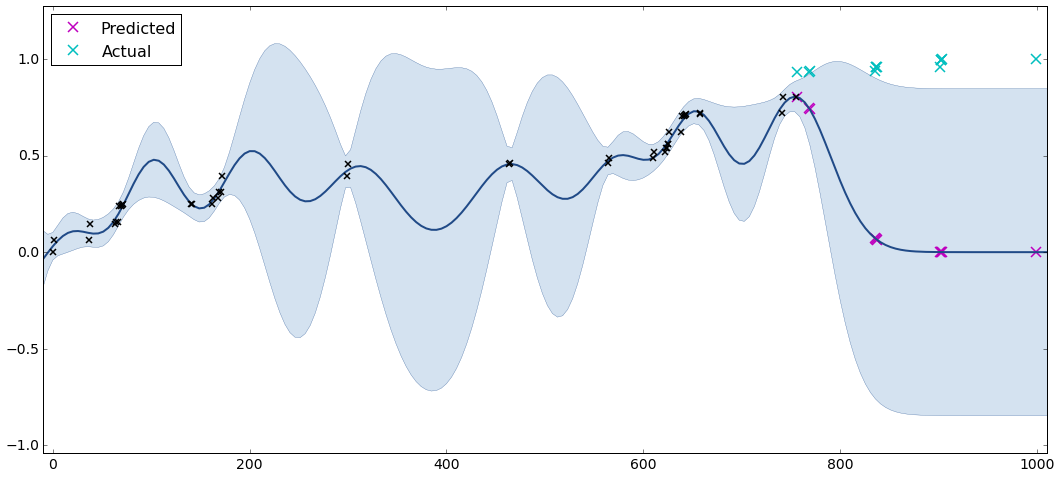

In [477]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

Xnew = np.ndarray((len(Xtest),1), buffer=Xtest, dtype=int)
mean, var = m.predict(Xnew)
Ypredict = mean

print "RMSE on test set: %s" % rmse(Ytest, Ypredict)
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.errorbar(Xnew, Ypredict, 2*np.sqrt(var), color='r', marker='x', linestyle=".")
ax.plot(Xnew, Ypredict, 'mx', mew=1.5, ms=10, label="Predicted")
ax.plot(Xtest, Ytest, 'cx', mew=1.5, ms=10, label="Actual")
ax.legend(loc=2, numpoints=1)
model_plot = m.plot(ax=ax, plot_limits=[-10, 1010])